## Постановка задачи
Загрузим уменьшенные изображения, уменьшим их еще в 2.5 раза и применим к ним дополнение (augmentation): смещение, контрастность, поворот, размытие.

Загрузим данные и разделим их на обучающие и проверочные в соотношении 80/20.

Используем Keras для построения нейросети с линейным, сверточными слоями и слоями подвыборки.

Обучим модель, используя последовательную загрузку данных. Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from scipy import ndimage
from skimage import transform,util,exposure,io,color
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


### Используемые функции

In [28]:
image_x = 210 # 525
image_y = 140 # 350
image_ch = 1 # 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        x[j] = io.imread(os.path.join(filesDir, file))
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size   
            batch_end += batch_size

def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

### Обработка и дополнение изображений
Преобразуем изображение: уменьшим в 2,5 раза, добавим случайный шум, повернем на 5 градусов по часовой и против часовой стрелки, увеличим контрастность, изменим гамму и добавим размытие по 3 и 7 пикселям

In [7]:
def img_save (name, data):
    io.imsave(os.path.join(filesDir, name),
             (data*255).astype(np.uint8))
def img_aug (name):
    if not os.path.isdir(filesDir):
        os.mkdir(filesDir)
    img = io.imread(os.path.join(dir_, name))
    img = transform.rescale(img, 1 / 2.5)
    img_save(name, img)
    img_save("noised_" + name, util.random_noise(img))
    img_save("rotcw_" + name, transform.rotate(img, -5))
    img_save("rotccw_" + name, transform.rotate(img, 5))
    v_min, v_max = np.percentile(img, (0.2, 99.8))
    img_save("cont_" + name, exposure.rescale_intensity(img,
                                in_range=(v_min, v_max)))
    img_save("gamma_" + name, exposure.adjust_gamma(img,
                                gamma=0.4, gain=0.9))
    img_save("blurred3_" + name,
            ndimage.uniform_filter(img, size=(3,3,1)))
    img_save("blurred7_" + name,
            ndimage.uniform_filter(img, size=(7,7,1)))

Обработаем все изображения обучающей выборки

In [5]:
dir_ = "train_images_small"
filesDir = dir_ + "_tiny"

In [8]:
for file in os.listdir(dir_):
    img_aug(file)

### Загрузка данных

In [9]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [10]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [11]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
16844  373 500 1773 500 3173 500 4573 500 5973 500 73...  c2ad0d8.jpg  Fish
18724                                                NaN  d90e620.jpg  Fish
6816   423255 412 424655 412 426055 412 427455 412 42...  4e60552.jpg  Fish
1064                                                 NaN  0ca6ecd.jpg  Fish
9928                                                 NaN  7100409.jpg  Fish


### Дополнение обучающих данных
Дополним все измененные изображения типами и областями облаков

In [12]:
train.set_index("Image", inplace=True)
fileList = os.listdir(filesDir)
for file in fileList:
    img = file.split("_")
    if (file not in train.index.values and len(img) > 1 and
       img[1] in train.index.values):
        train.loc[file] = [train.loc[img[1]]["EncodedPixels"], "Fish"]
train.reset_index(inplace=True)
print (train.head())

         Image                                      EncodedPixels Label
0  c2ad0d8.jpg  373 500 1773 500 3173 500 4573 500 5973 500 73...  Fish
1  d90e620.jpg                                                NaN  Fish
2  4e60552.jpg  423255 412 424655 412 426055 412 427455 412 42...  Fish
3  0ca6ecd.jpg                                                NaN  Fish
4  7100409.jpg                                                NaN  Fish


### Сверточная нейросеть
Создадим и построим модель

In [13]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(image_y, image_x, image_ch),
          kernel_initializer="glorot_uniform", strides=(2,2)),
    Activation("relu"),
    Conv2D(32, (3,3),
          kernel_initializer="glorot_uniform", strides=(2,2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Activation("softmax"),
    Dense(1)
])

In [14]:
model.compile(optimizer=optimizers.Nadam(lr=0.02),
             loss="mean_absolute_error")

### Обучение модели
Используем для обучения все изображения, включая измененные

In [15]:
batch_size=100

In [16]:
model.fit_generator(load_data(train, batch_size),
            epochs=100, steps_per_epoch=len(train)//batch_size)

Epoch 1/100
354/354 [==============================] - 483s 1s/step - loss: 0.4640
Epoch 2/100
354/354 [==============================] - 252s 712ms/step - loss: 0.4807
Epoch 3/100
354/354 [==============================] - 250s 706ms/step - loss: 0.4722
Epoch 4/100
354/354 [==============================] - 250s 707ms/step - loss: 0.4618
Epoch 5/100
354/354 [==============================] - 251s 708ms/step - loss: 0.4616
Epoch 6/100
354/354 [==============================] - 255s 720ms/step - loss: 0.4633
Epoch 7/100
354/354 [==============================] - 247s 697ms/step - loss: 0.4607
Epoch 8/100
354/354 [==============================] - 248s 702ms/step - loss: 0.4565
Epoch 9/100
354/354 [==============================] - 248s 700ms/step - loss: 0.4642
Epoch 10/100
354/354 [==============================] - 252s 713ms/step - loss: 0.4624
Epoch 11/100
354/354 [==============================] - 246s 694ms/step - loss: 0.4563
Epoch 12/100
354/354 [==============================] -

354/354 [==============================] - 245s 693ms/step - loss: 0.4417
Epoch 96/100
354/354 [==============================] - 246s 695ms/step - loss: 0.4435
Epoch 97/100
354/354 [==============================] - 247s 696ms/step - loss: 0.4418
Epoch 98/100
354/354 [==============================] - 245s 693ms/step - loss: 0.4387
Epoch 99/100
354/354 [==============================] - 246s 695ms/step - loss: 0.4392
Epoch 100/100
354/354 [==============================] - 245s 693ms/step - loss: 0.4421


### Предсказание значений

In [17]:
prediction = model.predict_generator(load_data(test, 1),
                            steps=len(test), verbose=1)

1110/1110 [==============================] - 20s 18ms/step


In [19]:
prediction = np.transpose(prediction)

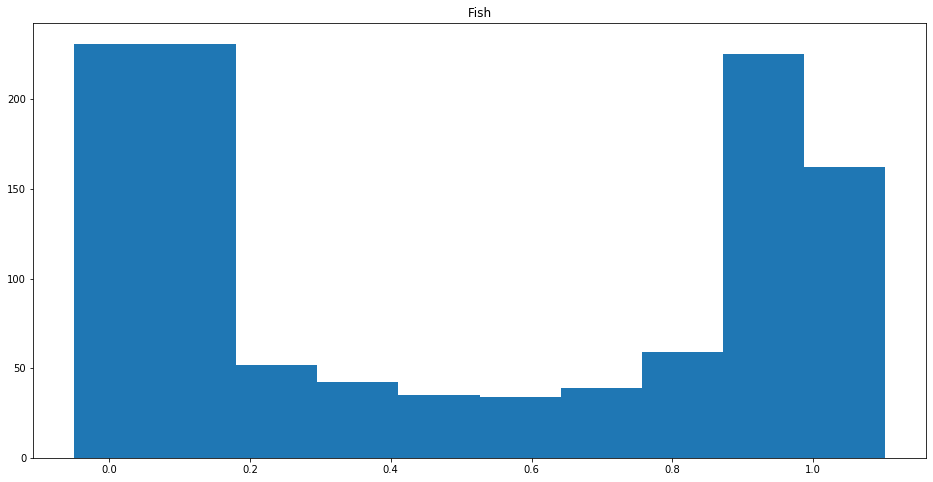

In [20]:
draw_prediction(prediction)

In [26]:
test["target"] = (prediction[0] >= 1).astype("int8")
print(test[test["target"]>0][["EncodedPixels","target"]].head(100))

                                           EncodedPixels  target
21880  946430 330 947830 330 949230 330 950630 330 95...       1
7960                                                 NaN       1
4292   158666 31 158698 6 160066 19 160086 1 160088 1...       1
21544  602756 314 604153 317 605526 1 605529 1 605532...       1
16888  450101 559 451501 559 452901 559 454301 559 45...       1
11092                                                NaN       1
548    564 535 1101 2 1104 1 1964 535 2501 1 3364 535...       1
11720                                                NaN       1
6184                                                 NaN       1
16660  791722 278 793122 278 794522 278 795922 278 79...       1
8      3510 690 4910 690 6310 690 7710 690 9110 690 1...       1
4808   830320 891 831720 891 833120 891 834520 891 83...       1
13308                                                NaN       1
19936                                                NaN       1
12                       

### Оценка по Дайсу
Пока будем считать, что при определении типа облака на изображении, оно целиком размещено на фотографии: т.е. область облака - это все изображение.

Нет облаков - 0.5, MLP - 0.3, CONV3-32x2,POOL2 - 0.48

In [29]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, (CONV3-32x2,POOL2):", round(dice.mean(), 3))

Keras, (CONV3-32x2,POOL2): 0.451
